# loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import darts
from darts.models.forecasting.arima import ARIMA
from darts import TimeSeries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os
import glob
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


# Helping Functions


In [3]:
import numpy as np


def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape, "MSE": mse}

    return metrics

# Data Reading 😶

In [25]:
fileName = "highcorrelated_features"
df = pd.read_csv(f"../ProcessedData/{fileName}/{fileName}.csv")
df.head()

,date,net_sales_total,net_order_entry_total,mitarbeiter_vertrieb,mitarbeiter_service,mitarbeiter_total
0,2014-01-31,9914.85,13197.85,94,178,272
1,2014-02-28,8793.66,11632.08,96,178,274
2,2014-03-31,12689.12,14404.37,97,179,276
3,2014-04-30,12420.60,11512.26,97,180,277
4,2014-05-31,11825.02,11875.16,99,178,277


In [5]:
df = df[["date", "net_sales_total"]]
df = df.drop_duplicates()
df.head()

,date,net_sales_total
0,2014-01-31,9914.85
1,2014-02-28,8793.66
2,2014-03-31,12689.12
3,2014-04-30,12420.60
4,2014-05-31,11825.02


In [6]:
df.isna().sum()

date               0
net_sales_total    0
dtype: int64

# Box-Jenkins Framework
The Box-Jenkins method is a statistical technique used for time series analysis and forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary or an ARIMA model if it is non-stationary.

The Box-Jenkins method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series2. The model can analyze several different types of time series data for forecasting purposes.

## ARIMA Model Pipeline
Autoregressive Integrated Moving Average (ARIMA) Model

* autoregressive models: AR(p)
* moving average models: MA(q)
* mixed autoregressive moving average models: ARMA(p, q)
* integration models: ARIMA(p, d, q)
### Stationary Test
What is stationary Data ?
Stationary data refers to time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.

* **Why we need stationary Data for ARIMA Model**  
ARIMA models rely on the assumption that the time series being modeled is stationary. Therefore that assumption needs to hold if you want to use these models. The ARIMA model uses differenced data to make the data stationary, which means there’s a consistency of the data over time. This function removes the effect of trends or seasonality, such as market or economic data. We make the data stationary only in case of ARIMA because the ARIMA model looks at the past data to predict future values.

# stationary Tesst

In [9]:
def adfuller_test(values):
    result = adfuller(values)
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print(
            "P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary"
        )
    else:
        print(
            "Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary "
        )

In [10]:
adfuller_test(df["net_sales_total"])

ADF Test Statistic : -0.5945418906256462
p-value : 0.8722105724767181
#Lags Used : 13
Number of Observations Used : 94
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


In [11]:
adfuller_test(df["net_sales_total"].diff(1).iloc[1:])

ADF Test Statistic : -4.015772404893064
p-value : 0.0013301372561128658
#Lags Used : 12
Number of Observations Used : 94
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## Spliting Data into Training & Testing Data

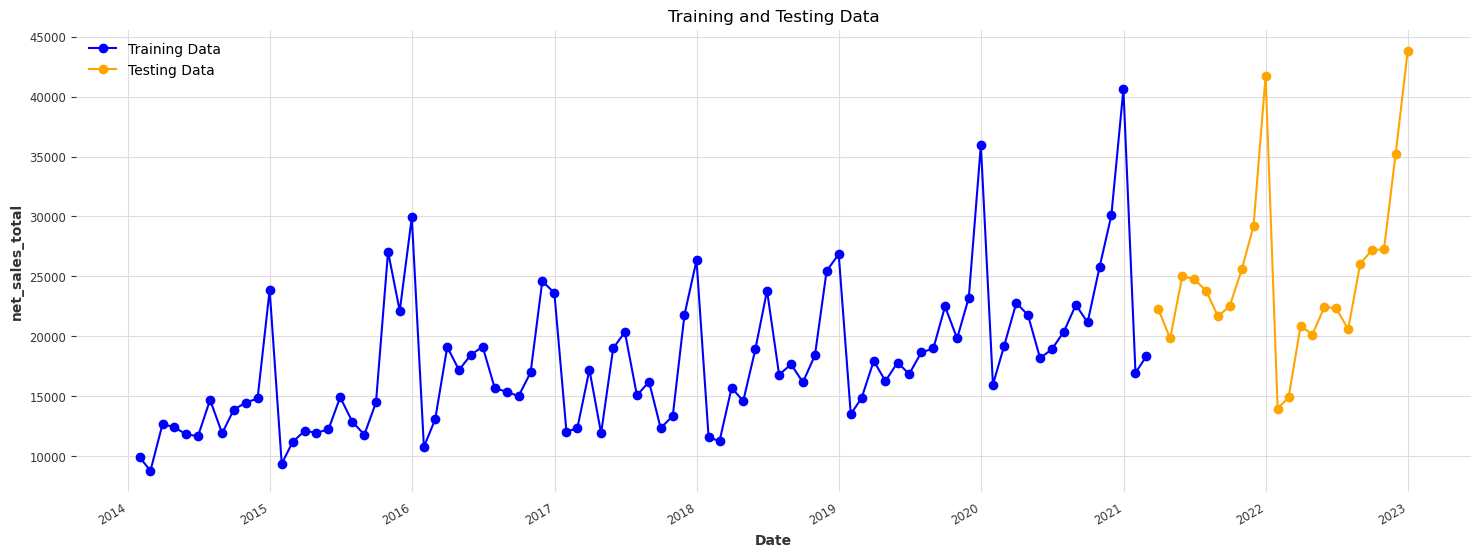

In [12]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(
    df, "date", "net_sales_total", freq="1M", fill_missing_dates=True, fillna_value=0
)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_series.plot(label="Training Data", color="blue", linewidth=1.5, marker="o")
test_series.plot(label="Testing Data", color="orange", linewidth=1.5, marker="o")

# Add title and labels
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("net_sales_total")

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

## Inspect Seasonality

In [13]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 6.
There is seasonality of order 12.
There is seasonality of order 15.
There is seasonality of order 18.


## Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the **MA** component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

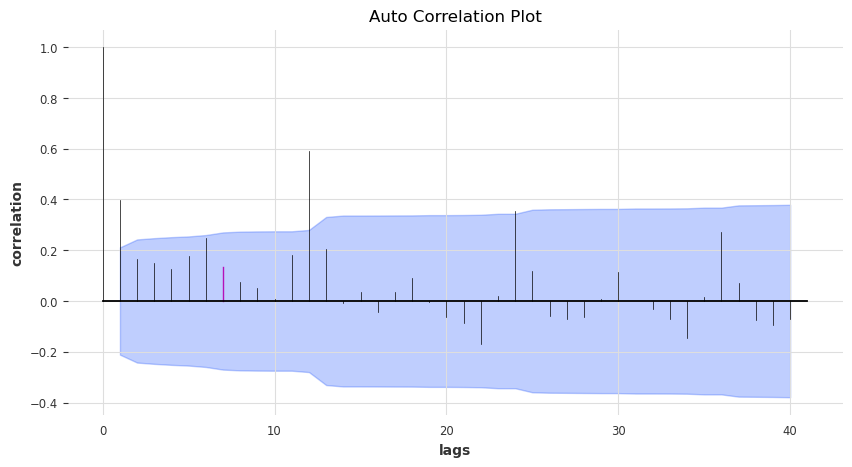

In [15]:
from darts.utils.statistics import plot_acf, plot_pacf


plot_acf(
    train_series, m=7, max_lag=40, fig_size=(10, 5), axis=None, default_formatting=True
)
plt.xlabel("lags")
plt.ylabel("correlation")
plt.title("Auto Correlation Plot")
plt.show()

## Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the **AR** component of the ARIMA model.

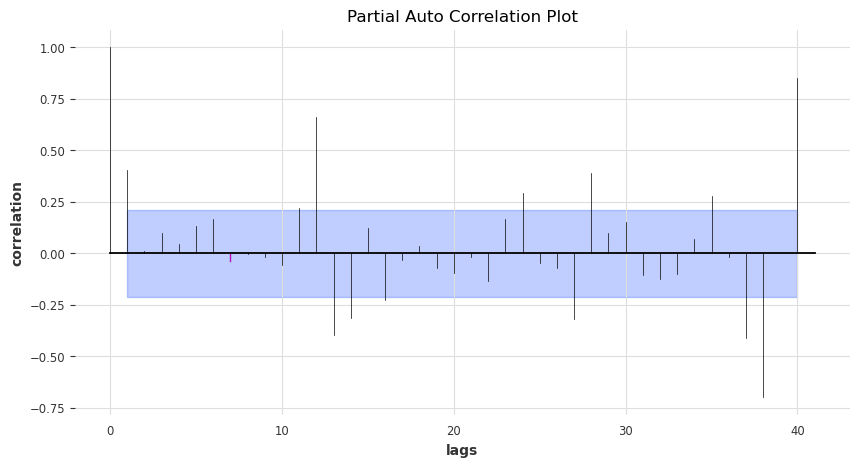

In [16]:
from darts.utils.statistics import plot_acf, plot_pacf

plot_pacf(
    train_series, m=7, max_lag=40, fig_size=(10, 5), axis=None, default_formatting=True
)

plt.xlabel("lags")
plt.ylabel("correlation")
plt.title("Partial Auto Correlation Plot")
plt.show()

# Model Fitting

## SARIMA Model

In [17]:
sarima_model = ARIMA(
    p=12,
    d=1,
    q=12,
    trend=None,
    random_state=1999,
    seasonal_order=(2, 1, 2, 18),
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["hour", "dayofweek"]},
        "position": {"future": ["relative"]},
        "custom": {"future": [lambda idx: (idx.year - 1950) / 50]},
        "transformer": Scaler(),
    },
)

sarima_model.fit(train_series)
sarima_model.model.summary()

/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   86
Model:             ARIMA(12, 1, 12)x(2, 1, [1, 2], 18)   Log Likelihood                -629.894
Date:                                 Fri, 15 Sep 2023   AIC                           1329.788
Time:                                         21:20:25   BIC                           1406.952
Sample:                                              0   HQIC                          1360.322
                                                  - 86                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3697.7730   1290.188      2.866      0.004    1169.051    6226.495
x2           599.2525   1013.212      0.591      0.554   -1386.606    2585.111
const       7.753e-14   7.03e+04    1.1e-18      1.000   -1.38e+05    1.38e+05
x3          -399.3426   1062.285     -0.376      0.707   -2481.384    1682.698
x4             0.0001   7.16e+04   1.78e-09      1.000    -1.4e+05     1.4e+05
x5         -1.198e+05   1.92e+04     -6.233      0.000   -1.58e+05   -8.22e+04
ar.L1          0.1315     24.089      0.005      0.996     -47.081      47.344
ar.L2         -0.4271     13.278     -0.032      0.974     -26.451      25.597
ar.L3          0.1503     18.739      0.008      0.994     -36.578      36.878
ar.L4         -0.8421      8.397     -0.100      0.920     -17.299      15.615
ar.L5          0.1483     24.928      0.006      0.995     -48.710      49.006
ar.L6          0.0206     12.629      0.002      0.999     -24.731      24.773
ar.L7         -0.2456      7.294     -0.034      0.973     -14.542      14.051
ar.L8         -0.1998      9.522     -0.021      0.983     -18.862      18.463
ar.L9          0.0604     10.340      0.006      0.995     -20.206      20.327
ar.L10         0.3492      4.894      0.071      0.943      -9.244       9.942
ar.L11        -0.2664      6.177     -0.043      0.966     -12.373      11.840
ar.L12         0.0291      1.664      0.018      0.986      -3.233       3.291
ma.L1         -0.9438     71.366     -0.013      0.989    -140.819     138.932
ma.L2          0.5617     93.940      0.006      0.995    -183.556     184.680
ma.L3         -0.6637    119.529     -0.006      0.996    -234.936     233.609
ma.L4          0.7954    150.988      0.005      0.996    -295.135     296.726
ma.L5         -0.6084    185.444     -0.003      0.997    -364.071     362.855
ma.L6         -0.2315    211.024     -0.001      0.999    -413.831     413.368
ma.L7          0.6593    202.214      0.003      0.997    -395.673     396.992
ma.L8         -0.9078    176.653     -0.005      0.996    -347.141     345.325
ma.L9          0.4453    128.625      0.003      0.997    -251.655     252.545
ma.L10        -0.7703    115.551     -0.007      0.995    -227.245     225.705
ma.L11         1.1103     84.437      0.013      0.990    -164.384     166.604
ma.L12        -0.4450     31.813     -0.014      0.989     -62.797      61.907
ar.S.L18      -1.0486      0.848     -1.237      0.216      -2.710       0.613
ar.S.L36      -0.5136      0.311     -1.654      0.098      -1.122       0.095
ma.S.L18      -0.0692     64.286     -0.001      0.999    -126.068     125.929
ma.S.L36      -0.9246     64.752     -0.014      0.989    -127.836     125.987
sigma2      3.186e+06        nan        nan        nan         nan         nan
===================================================================================
Lj

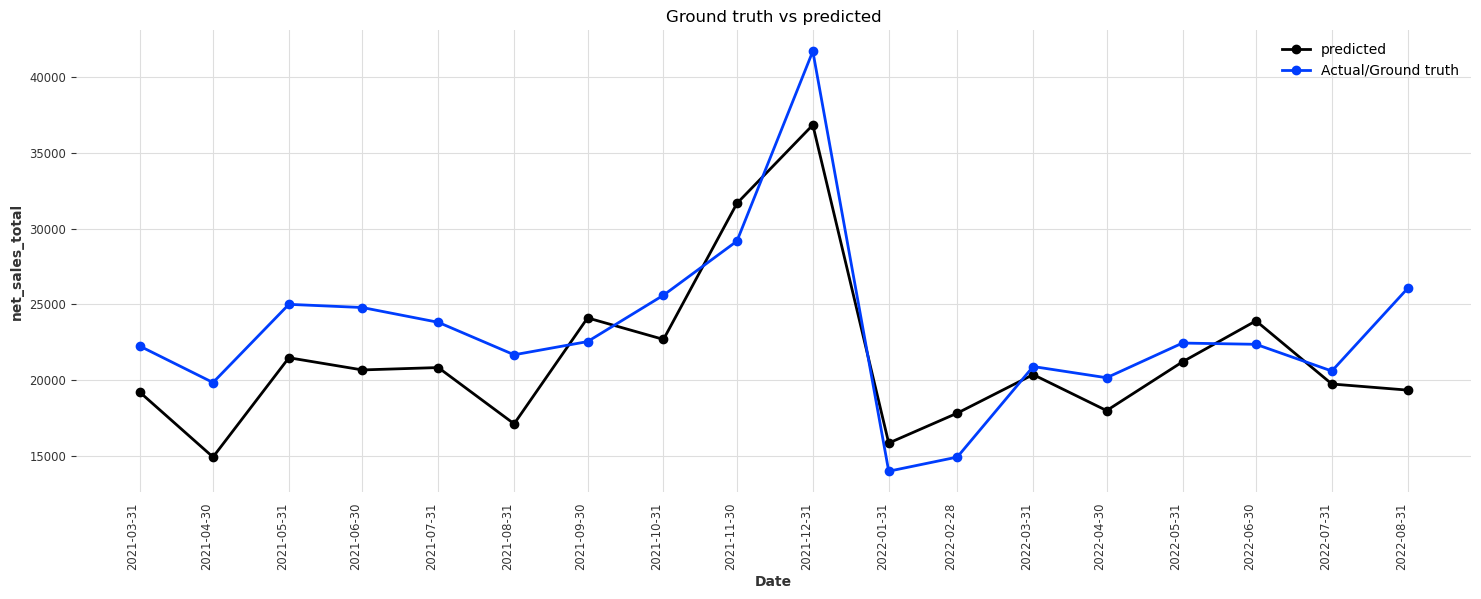

In [18]:
horizan = 18
test_series_ = test_series[0:horizan]
plt.figure(figsize=(18, 6))

forcast_arima = sarima_model.predict(horizan)
sarima_model.predict(horizan).plot(marker="o", label="predicted")
test_series_.plot(marker="o", label="Actual/Ground truth")
# Add title and labels
plt.title("Ground truth vs predicted")
plt.xlabel("Date")
plt.ylabel("net_sales_total")
plt.xticks(
    forcast_arima.time_index, forcast_arima.time_index.strftime("%Y-%m-%d"), rotation=90
)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.savefig(
    f"../ProcessedData/Results/ARIMA/highcorrelated_features/ARIMA_Plots/utilized_all.png"
)
plt.show()

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Function to predict and evaluate
def predict_and_evaluate(
    window_size,
    prediction_horizon,
    slide_step,
    test_series,
    arima_model,
    result_plot_path,
):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1

    meta_information_evaluation = {
        "Iterations": [],
        "MAE": [],
        "RMSE": [],
        "MAPE": [],
        "MSE": [],
        "input_window_size": [],
        "horizon": [],
        "stride": [],
    }

    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i : i + window_size]
            ground_truth = test_series[
                i + window_size : i + window_size + prediction_horizon
            ]
            forecast = arima_model.predict(n=prediction_horizon, series=input_window)
            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()
            metrics = calculate_metrics(actual, predicted)

            meta_information_evaluation["Iterations"].append(i)
            meta_information_evaluation["MAE"].append(metrics["MAE"])
            meta_information_evaluation["RMSE"].append(metrics["RMSE"])
            meta_information_evaluation["MAPE"].append(metrics["MAPE"])
            meta_information_evaluation["MSE"].append(metrics["MSE"])
            meta_information_evaluation["input_window_size"].append(window_size)
            meta_information_evaluation["horizon"].append(prediction_horizon)
            meta_information_evaluation["stride"].append(slide_step)

            bypass_information = {
                "slide_step": slide_step,
                "window_size": window_size,
                "horizon": prediction_horizon,
            }
            create_plots(
                input_window,
                forecast,
                ground_truth,
                result_plot_path,
                bypass_information,
            )

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df

    except Exception as e:
        print("Error Occurred in fuction predict_and_evaluate():", e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df


# Function to create plots
def create_plots(
    input_window, forecast, ground_truth, result_plot_path, bypass_information
):
    plt.figure(figsize=(30, 6))
    input_window.plot(label="Input Data", marker="o")
    forecast.plot(label="Predicted", marker="o")
    ground_truth.plot(label="Ground Truth", marker="o")

    combined_time_index = input_window.time_index.append(forecast.time_index).append(
        ground_truth.time_index
    )
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")

    plt.xticks(
        combined_time_index, combined_time_index.strftime("%Y-%m-%d"), rotation=90
    )
    plt.title(
        f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}",
        fontsize=16,
    )
    plt.ylabel("Amazon Close Price", fontsize=14)
    plt.xlabel("Dates", fontsize=14)
    plt.legend()

    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()

# Model Evaluation

In [22]:
def model_evaluation(model_name, model_object, test_series, FileName):
    result_path = f"../ProcessedData/Results/{model_name}/{FileName}"
    result_plot_path = (
        f"../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots"
    )
    os.makedirs(result_path, exist_ok=True)
    os.makedirs(result_plot_path, exist_ok=True)

    # Set your parameters
    window_sizes = [6, 12, 18]
    prediction_horizons = [6, 12, 18]
    slide_steps = [2, 5, 8]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(
                    f"Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}"
                )
                evaluation_df = predict_and_evaluate(
                    window_size,
                    prediction_horizon,
                    slide_step,
                    test_series,
                    model,
                    result_plot_path,
                )
                evaluation_df.to_csv(
                    f"{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv",
                    index=False,
                )

                print(
                    f"Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed."
                )
        #         break
        #     break
        # break

## SARIMA Model Evaluation

In [23]:
model_name = "SARIMA"
model_object = sarima_model
FileName = fileName
test_series = test_series
model_evaluation(model_name, model_object, test_series, FileName)

Iteration : Window size : 6 Horizan: 6, Stride : 2


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Window_size_6_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 5


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Window_size_6_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 8


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Window_size_6_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 2


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Window_size_6_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 5


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Window_size_6_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 8


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Window_size_6_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 2


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Window_size_12_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 5


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Window_size_12_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 8


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Window_size_12_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 8


0it [00:00, ?it/s]

Window_size_18_prediction_horizon_18_slide_step_8 - Evaluation completed.


# Evaluate metrics

In [28]:
import pandas as pd
import glob


def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        "window_size": [],
        "horizan": [],
        "stride": [],
        "AVG_MAE": [],
        "AVG_MSE": [],
        "AVG_RMSE": [],
        "AVG_MAPE": [],
    }

    paths = glob.glob(file_pattern)

    for path in paths:
        window_size = path.split("/")[-1].split("_")[2]
        horizan = path.split("/")[-1].split("_")[4]
        stride = path.split("/")[-1].split("_")[6].split(".")[0]

        df = pd.read_csv(path)
        eval_dict["window_size"].append(window_size)
        eval_dict["horizan"].append(horizan)
        eval_dict["stride"].append(stride)

        eval_dict["AVG_MAE"].append(df["MAE"].mean())
        eval_dict["AVG_MSE"].append(df["MSE"].mean())
        eval_dict["AVG_RMSE"].append(df["RMSE"].mean())
        eval_dict["AVG_MAPE"].append(df["MAPE"].mean())

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(
        ["window_size", "horizan", "stride"], inplace=True, ascending=True
    )

    return eval_df


# Example usage
file_pattern = f"../ProcessedData/Results/SARIMA/{fileName}/*.csv"
result_df = aggregate_evaluation_results(file_pattern)
# result_df = result_df[
#     ["window_size", "horizan", "stride", "AVG_MAE", "AVG_MSE", "AVG_RMSE"]
# ]
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,10855.181786,2.218483e+08,14846.134275,42.141962
13,12,6,5,10310.593831,1.786404e+08,13365.640666,44.405902
0,12,6,8,10310.593831,1.786404e+08,13365.640666,44.405902
19,6,12,2,28024.183079,1.056891e+09,32507.635601,129.206317
9,6,12,5,27650.073007,1.081246e+09,32882.307635,125.204871
22,6,12,8,27650.073007,1.081246e+09,32882.307635,125.204871
17,6,6,2,35382.421244,1.717726e+09,41259.033101,154.013834
16,6,6,5,35973.711602,1.792509e+09,42160.245321,146.412696
5,6,6,8,35187.730503,1.763301e+09,41929.945602,148.406627


In [29]:
for name, group in result_df.groupby(["window_size", "horizan"]):
    print(name)
    display(group)

('12', '6')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,10855.181786,2.218483e+08,14846.134275,42.141962
13,12,6,5,10310.593831,1.786404e+08,13365.640666,44.405902
0,12,6,8,10310.593831,1.786404e+08,13365.640666,44.405902


('6', '12')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
19,6,12,2,28024.183079,1.056891e+09,32507.635601,129.206317
9,6,12,5,27650.073007,1.081246e+09,32882.307635,125.204871
22,6,12,8,27650.073007,1.081246e+09,32882.307635,125.204871


('6', '6')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
17,6,6,2,35382.421244,1.717726e+09,41259.033101,154.013834
16,6,6,5,35973.711602,1.792509e+09,42160.245321,146.412696
5,6,6,8,35187.730503,1.763301e+09,41929.945602,148.406627
